In [1]:
import math
import yaml
import warnings
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from yaml import Loader
from pcse.util import WOFOST71SiteDataProvider
from pcse.fileinput import YAMLCropDataProvider

import pcse
from pcse.models import Wofost71_WLP_FD, Wofost72_WLP_FD
from pcse.fileinput import CABOFileReader, YAMLCropDataProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import WOFOST71SiteDataProvider, DummySoilDataProvider
from pcse.base import ParameterProvider

from ast import literal_eval

from pcse.base import WeatherDataContainer, WeatherDataProvider
from pcse.util import reference_ET, angstrom, check_angstromAB
from pcse.exceptions import PCSEError
from pcse.settings import settings

In [2]:
from utils import ForecastConverter
from utils import vangen_direct, rosseta

In [3]:
# sys.path.append('../soil')
# from ANN_Module import PTF_MODEL
# from DB_Module import DB

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 12)

In [5]:
warnings.filterwarnings("ignore")

In [6]:
# class ParseError(PCSEError):
#     pass

# class OutOfRange(PCSEError):
#     pass

# class IRRADFromSunshineDuration:

#     def __init__(self, latitude, angstA, angstB):

#         assert -90 < latitude < 90, \
#             "Invalid latitude value (%s) encountered" % latitude
#         check_angstromAB(angstA, angstB)
#         self.latitude = latitude
#         self.angstA = angstA
#         self.angstB = angstB

#     def __call__(self, value, day):
#         """Computes irradiance in J/m2/day from sunshine duration by applying the Angstrom equation

#         :param value: sunshine duration in hours
#         :param day: the day
#         :return: irradiance in J/m2/day
#         """
#         assert 0 <= value <= 24, \
#             "Invalid sunshine duration value (%s) encountered at day %s" % (value, day)
#         irrad = angstrom(day, self.latitude, value, self.angstA, self.angstB)

#         return irrad

# def csvdate_to_date(x, dateformat):
#     """Converts string x to a datetime.date using given format.

#     :param x: the string representing a date
#     :param dateformat: a strptime() accepted date format
#     :return: a date
#     """
#     return dt.datetime.strptime(x, dateformat).date()

# # Conversion functions
# def NoConversion(x, d):
#     return float(x)


# def kJ_to_J(x, d):
#     return float(x)*1000.


# def mm_to_cm(x, d):
#     return float(x)/10.


# def kPa_to_hPa(x, d):
#     return float(x)*10.

# class ForecastConverter(WeatherDataProvider):
#     """Reading weather data from pandas.DataFrame into PCSE Weather Container.
#     :df pandas.DataFrame with weather records
#     :param dateformat: date format to be read. Default is '%Y%m%d'
#     :keyword ETmodel: "PM"|"P" for selecting Penman-Monteith or Penman
#         method for reference evapotranspiration. Default is 'PM'.
#     :metainfo dict with general info 
#         ## Site Characteristics
#         Country     = 'Netherlands'
#         Station     = 'Wageningen, Haarweg'
#         Description = 'Observed data from Station Haarweg in Wageningen'
#         Source      = 'Meteorology and Air Quality Group, Wageningen University'
#         Contact     = 'Peter Uithol'
#         Longitude = 5.67; Latitude = 51.97; Elevation = 7; AngstromA = 0.18; AngstromB = 0.55; HasSunshine = False
#         ## Daily weather observations (missing values are NaN)
#         DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH
#     """

#     obs_conversions = {
#         "TMAX": NoConversion,
#         "TMIN": NoConversion,
#         "IRRAD": kJ_to_J,
#         "VAP": kPa_to_hPa,
#         "WIND": NoConversion,
#         "RAIN": mm_to_cm,
#         "SNOWDEPTH": NoConversion
#     }

#     def __init__(self, metainfo:dict,
#                  df: pd.DataFrame,
#                  dateformat:str='%Y-%m-%d',
#                  ETmodel:str='PM', 
#                  force_reload:bool=False):
        
#         WeatherDataProvider.__init__(self)
#         self.dateformat = dateformat
#         self.ETmodel = ETmodel
        
#         self._read_meta(metainfo)
        
#         self._read_observations(df)

#     def _read_meta(self, metainfo):
#         header = metainfo

#         self.nodata_value = -99
#         self.description = [u"Weather data for:",
#                             u"Country: %s" % header['Country'],
#                             u"Station: %s" % header['Station'],
#                             u"Description: %s" % header['Description'],
#                             u"Source: %s" % header['Source'],
#                             u"Contact: %s" % header['Contact']]

#         self.longitude = float(header['Longitude'])
#         self.latitude = float(header['Latitude'])
#         self.elevation = float(header['Elevation'])
#         angstA = float(header['AngstromA'])
#         angstB = float(header['AngstromB'])
#         self.angstA, self.angstB = check_angstromAB(angstA, angstB)
#         self.has_sunshine = bool(header['HasSunshine'])
#         # If the file has sunshine duration, we replace the convertor with the angstrom module
#         if self.has_sunshine:
#             self.obs_conversions["IRRAD"] = IRRADFromSunshineDuration(self.latitude, self.angstA, self.angstB)

#     def _read_observations(self, df: pd.DataFrame):
#         """Processes the pandas DataFrame with meteo data
#            and converts into the correct units.
#         """
#         for i, d in df.iterrows():
#             try:
#                 day = None
#                 day = csvdate_to_date(d.pop("DAY"), self.dateformat)
#                 row = {"DAY":  day}
#                 for label in self.obs_conversions.keys():
#                     func = self.obs_conversions[label]
#                     value = float(d[label])
#                     r = func(value, day)
#                     if math.isnan(r):
#                         if label == "SNOWDEPTH":
#                             continue
#                         raise ParseError
#                     row[label] = r
#                 # Reference ET in mm/day
#                 e0, es0, et0 = reference_ET(LAT=self.latitude, ELEV=self.elevation,
#                                             ANGSTA=self.angstA, ANGSTB=self.angstB,
#                                             ETMODEL=self.ETmodel, **row)
#                 # convert to cm/day
#                 row["E0"] = e0/10.
#                 row["ES0"] = es0/10.
#                 row["ET0"] = et0/10.

#                 wdc = WeatherDataContainer(LAT=self.latitude, 
#                                            LON=self.longitude,
#                                            ELEV=self.elevation, **row)
#                 self._store_WeatherDataContainer(wdc, day)
#             except (ParseError, KeyError):
#                 msg = "Failed reading element '%s' for day '%s' at line %i. Skipping ..." % (label, day, i)
#                 self.logger.warn(msg)
#             except ValueError as e:  # strange value in cell
#                 msg = "Failed computing a value for day '%s' at row %i" % (day, i)
#                 self.logger.warn(msg)
                
# def rosseta(data_in, n_model=3):
#     with DB(host='localhost', 
#             user='root',
#             db_name='Rosetta',
#             sqlite_path='./soil/sqlite/Rosetta.sqlite') as db:
#         ptf_model=PTF_MODEL(n_model, db)
#         data=data_in
#         raw=False
#         if not raw:
#             res_dict = ptf_model.predict(data,sum_data=True) 
#             vgm_name=res_dict['var_names']
#             vgm_mean=res_dict['sum_res_mean']
#             vgm_new=np.stack((vgm_mean[0],vgm_mean[1],10**vgm_mean[2],10**vgm_mean[3],10**vgm_mean[4]))
#             vgm_new=vgm_new.transpose()
#             return vgm_new
#         else:
#             res_dict = ptf_model.predict(data,sum_data=False)  
#             return res_dict

# def vangen_direct(theta_r, theta_s, alpha, n, psy: int):
#     return theta_r + (theta_s - theta_r) \
#             / ((1 + (alpha * psy) ** n)) ** (1 - 1 / n)

# Weather

In [7]:
weather_df = pd.read_csv('../weather/weather2015-2020.csv')
weather_forecast_df = pd.read_csv('../weather/weather_forecast_2015-2020.csv')
weather_part_forecast_df = pd.read_csv('../weather/weather_partforecast_2015-2020.csv')
display(weather_df.head())
display(weather_part_forecast_df.head())
display(weather_forecast_df.head())

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH
0,20150101,1570.0,-13.97,-5.31,0.296775,4.51,0.68,NaN
1,20150102,1510.0,-5.18,-0.77,0.492191,5.11,0.96,NaN
2,20150103,2320.0,-2.38,0.68,0.571513,6.33,1.14,NaN
3,20150104,1530.0,-4.93,-0.16,0.506322,5.75,0.59,NaN
4,20150105,1800.0,-11.96,-2.27,0.369812,3.33,1.33,NaN


,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH
0,20150101,2444.759620,-10.635813,-4.995574,0.349984,4.51,0.68,NaN
1,20150102,2575.333388,-10.739816,-5.091093,0.342068,5.11,0.96,NaN
2,20150103,2625.551686,-10.854426,-5.019448,0.349538,6.33,1.14,NaN
3,20150104,2699.011603,-10.948030,-5.111563,0.348583,5.75,0.59,NaN
4,20150105,2611.028557,-11.031238,-5.121399,0.348555,3.33,1.33,NaN


,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH
0,20150101,2444.759620,-10.635813,-4.995574,0.349984,3.627238,1.783456,NaN
1,20150102,2575.333388,-10.739816,-5.091093,0.342068,3.593381,1.533375,NaN
2,20150103,2625.551686,-10.854426,-5.019448,0.349538,3.550257,1.762349,NaN
3,20150104,2699.011603,-10.948030,-5.111563,0.348583,3.520703,1.730274,NaN
4,20150105,2611.028557,-11.031238,-5.121399,0.348555,3.496088,1.713361,NaN


In [8]:
metainfo = {
    "Country": "Russia",
    "Station" : "Kshen",
    "Description": "Forecast for Kshen, Kursk",
    "Source": "MSU",
    "Contact": "imirpulatov@yandex.ru",
    "Longitude": 37.25,
    "Latitude": 51.43,
    "Elevation": 150,
    "AngstromA": 0.18,
    "AngstromB": 0.55,
    "HasSunshine": False
}

In [9]:
# Convert int format of DAY into str
weather_df.loc[:, 'DAY'] = weather_df.loc[:, 'DAY'].astype(str)
weather_forecast_df.loc[:, 'DAY'] = weather_forecast_df.loc[:, 'DAY'].astype(str)
weather_part_forecast_df.loc[:, 'DAY'] = weather_part_forecast_df.loc[:, 'DAY'].astype(str)

weather_crop_model = ForecastConverter(
    metainfo=metainfo,
    df=weather_df,
    dateformat="%Y%m%d"
)
weather_forecast_crop_model = ForecastConverter(
    metainfo=metainfo, 
    df=weather_forecast_df,
    dateformat="%Y%m%d"
)
weather_part_forecas_crop_model = ForecastConverter(
    metainfo=metainfo,
    df=weather_part_forecast_df,
    dateformat="%Y%m%d"
)

In [10]:
dictWeather = {
    'Observed': weather_crop_model,
    'Forecast Part': weather_forecast_crop_model,
    'Forecast': weather_part_forecas_crop_model
}

# Crop

In [11]:
cropd = YAMLCropDataProvider(repository="https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/master/"
)
cropd.set_active_crop(
    crop_name='sugarbeet',
    variety_name='Sugarbeet_603'
)

# Soil

In [12]:
soil_kshen =  [
    {
        "Thickness": [0.3, "m"],
        "SoilOrganicCarbon": [5.1, "%"],
        "KA5TextureClass": "Lu",
        "Sand":[0.037, "kg kg-1 (%[0-1])"],
        "Clay":[0.09, "kg kg-1 (%[0-1])"],
        "Skeleton":[0.02, "%[0-1]"],
        "PoreVolume":[0.566, "m3 m-3"],
        "FieldCapacity":[0.3, "m3 m-3"],
        "PermanentWiltingPoint":[0.15, "m3 m-3"],
        "pH":[6.213],
        "CN":[12.481],
        "SoilBulkDensity":[1126.625, "kg m-3"]
    }, 
    {
        "Thickness": [0.1, "m"],
        "SoilOrganicCarbon": [3.3, "%"],
        "KA5TextureClass": "Lu",
        "Sand":[0.045, "kg kg-1 (%[0-1])"],
        "Clay":[0.088, "kg kg-1 (%[0-1])"],
        "Skeleton":[0.02, "%[0-1]"],
        "PoreVolume":[0.594, "m3 m-3"],
        "FieldCapacity":[0.3, "m3 m-3"],
        "PermanentWiltingPoint":[0.15, "m3 m-3"],
        "pH":[6.397],
        "CN":[10.531],
        "SoilBulkDensity":[1056.667, "kg m-3"]
    }
]

In [13]:
# Here we consider only first soil layer (30 cm)
SOC = soil_kshen[0]['SoilOrganicCarbon']
Sand = soil_kshen[0]['Sand'][0] * 100
Clay = soil_kshen[0]['Clay'][0] * 100
Silt = 100 - (Sand + Clay)
BulkDensity = soil_kshen[0]['SoilBulkDensity'][0] / 1000.


# Rosseta function compute soil physics parameters for moddeling based
soil_PFT = rosseta(np.array([[Sand, Silt, Clay, BulkDensity]]).T)
col_names = [
    'theta_r',
    'theta_s',
    'alpha',
    'n',
    'Ks'
]
soil_df = pd.DataFrame(data=soil_PFT, columns=col_names)

# Compute fieldcapacity
soil_df['Field Capacity'] = vangen_direct(
    theta_r = soil_df['theta_r'],
    theta_s = soil_df['theta_s'],
    alpha = soil_df['alpha'],
    n = soil_df['n'],
    psy = 330
)

# Compute wilting point
soil_df['Wilting point'] = vangen_direct(
    theta_r = soil_df['theta_r'],
    theta_s = soil_df['theta_s'],
    alpha = soil_df['alpha'],
    n = soil_df['n'],
    psy = 15_000
)

soil_df.rename(columns={'alpha':'Wmin', 'theta_s':'Wmax'}, inplace=True)

In [14]:
soild = DummySoilDataProvider()
soild['SM0']=0.8
soild['SMW'] = soil_df['Wilting point'][0]
soild['SMFCF'] = soil_df['Field Capacity'][0]
soild['K0'] = soil_df['Ks'][0]

# Site

In [15]:
sited = WOFOST71SiteDataProvider(WAV=20)

# Scenario

In [16]:
yaml_agro_sugar_beat_2015 = f"""
- 2015-04-20:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2015-05-20
        crop_start_type: emergence
        crop_end_date: 2015-09-15
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
"""


yaml_agro_winter_wheat_2015 = f"""
- 2015-08-25:
    CropCalendar:
        crop_name: wheat
        variety_name: Winter_wheat_101
        crop_start_date: 2015-09-25
        crop_start_type: emergence
        crop_end_date: 2016-07-04
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
"""

yaml_agro_sugar_beat_2017 = f"""
- 2017-04-20:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2017-05-20
        crop_start_type: emergence
        crop_end_date: 2017-09-15
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
"""


yaml_agro_winter_wheat_2017 = f"""
- 2017-08-25:
    CropCalendar:
        crop_name: wheat
        variety_name: Winter_wheat_101
        crop_start_date: 2017-09-25
        crop_start_type: emergence
        crop_end_date: 2018-07-04
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
"""

# Sugar Beat - 2015

In [17]:
agromanagement = yaml.load(yaml_agro_sugar_beat_2015, Loader)
firstkey = list(agromanagement[0])[0]
cropcalendar = agromanagement[0][firstkey]['CropCalendar'] 
cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [18]:
resSB_2015 = {}
for key, value in dictWeather.items():
    # Part forecast weather
    wfst71_FLD = Wofost71_WLP_FD(
        params,
        value,
        agromanagement
    )
    wfst71_FLD.run_till_terminate()
    df_FLD = pd.DataFrame(wfst71_FLD.get_output())
    df_FLD = df_FLD.set_index("day")
    resSB_2015[key] = df_FLD

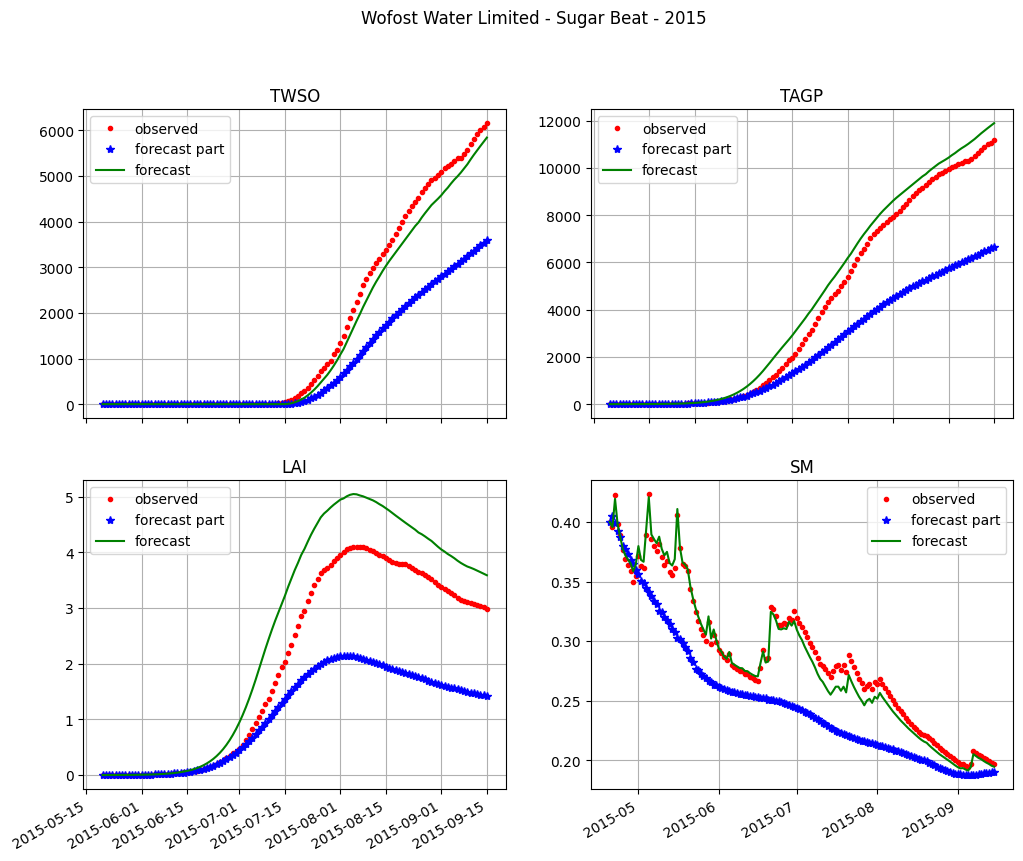

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for var, ax in zip(["TWSO", "TAGP", "LAI", "SM"], axes.flatten()):
    ax.plot_date(resSB_2015['Observed'].index, resSB_2015['Observed'][var], 'r.', label = 'observed')
    ax.plot_date(resSB_2015['Forecast Part'].index, resSB_2015['Forecast Part'][var], 'b*', label = 'forecast part')
    ax.plot_date(resSB_2015['Forecast'].index, resSB_2015['Forecast'][var], 'g-', label = 'forecast')
    ax.set_title(var)
    ax.grid()
    ax.legend()
fig.autofmt_xdate()
fig.suptitle('Wofost Water Limited - Sugar Beat - 2015')
fig.show()

In [20]:
crop_yield = np.round(resSB_2015['Observed']['TWSO'].values[-1], 2)
print(f"Crop yield - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")
crop_yield = np.round(resSB_2015['Forecast Part']['TWSO'].values[-1], 2)
print(f"Crop yield part forecast - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")
crop_yield = np.round(resSB_2015['Forecast']['TWSO'].values[-1], 2)
print(f"Crop yield forecast - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")

Crop yield - sugarbeet, Yield, kg/ha - 6158.55
Crop yield part forecast - sugarbeet, Yield, kg/ha - 3599.74
Crop yield forecast - sugarbeet, Yield, kg/ha - 5841.43


# Winter Wheat - 2015

In [21]:
agromanagement = yaml.load(yaml_agro_winter_wheat_2015, Loader)
firstkey = list(agromanagement[0])[0]
cropcalendar = agromanagement[0][firstkey]['CropCalendar'] 
cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [22]:
resWW_2015 = {}
for key, value in dictWeather.items():
    # Part forecast weather
    wfst71_FLD = Wofost71_WLP_FD(
        params,
        value,
        agromanagement
    )
    wfst71_FLD.run_till_terminate()
    df_FLD = pd.DataFrame(wfst71_FLD.get_output())
    df_FLD = df_FLD.set_index("day")
    resWW_2015[key] = df_FLD

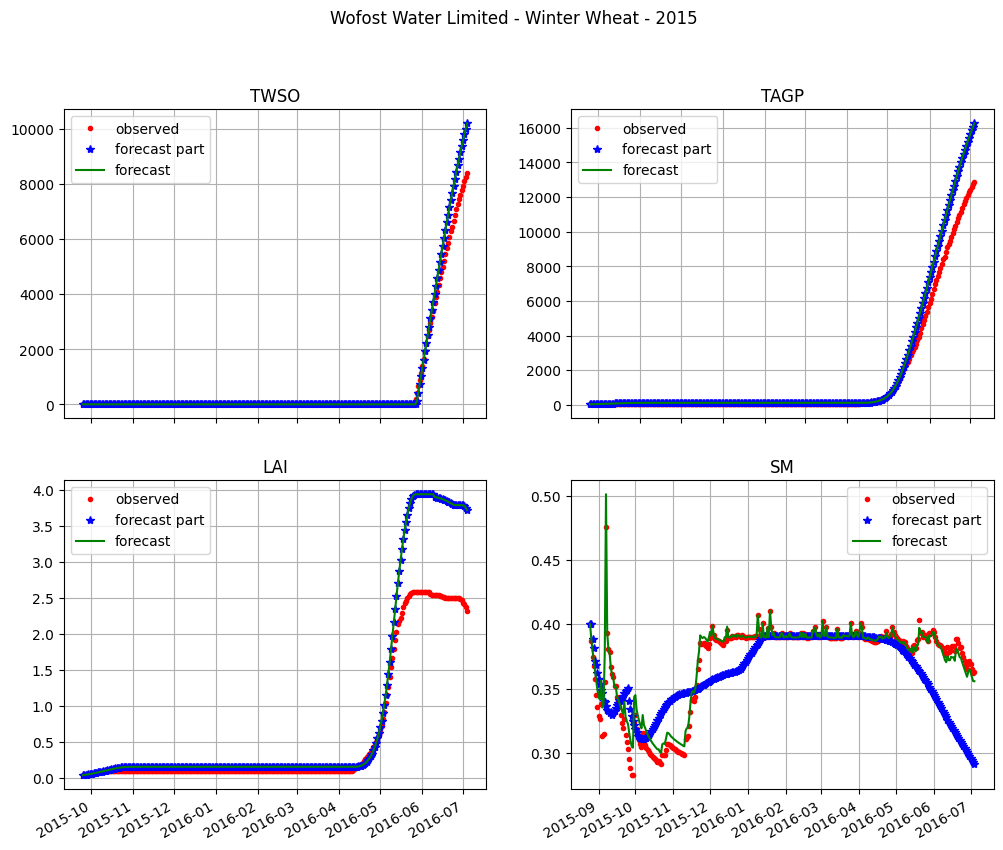

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for var, ax in zip(["TWSO", "TAGP", "LAI", "SM"], axes.flatten()):
    ax.plot_date(resWW_2015['Observed'].index, resWW_2015['Observed'][var], 'r.', label = 'observed')
    ax.plot_date(resWW_2015['Forecast Part'].index, resWW_2015['Forecast Part'][var], 'b*', label = 'forecast part')
    ax.plot_date(resWW_2015['Forecast'].index, resWW_2015['Forecast'][var], 'g-', label = 'forecast')
    ax.set_title(var)
    ax.grid()
    ax.legend()
fig.autofmt_xdate()
fig.suptitle('Wofost Water Limited - Winter Wheat - 2015')
fig.show()

In [24]:
crop_yield = np.round(resWW_2015['Observed']['TWSO'].values[-1], 2)
print(f"Crop yield - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")
crop_yield = np.round(resWW_2015['Forecast Part']['TWSO'].values[-1], 2)
print(f"Crop yield part forecast - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")
crop_yield = np.round(resWW_2015['Forecast']['TWSO'].values[-1], 2)
print(f"Crop yield forecast - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")

Crop yield - wheat, Yield, kg/ha - 8404.01
Crop yield part forecast - wheat, Yield, kg/ha - 10212.43
Crop yield forecast - wheat, Yield, kg/ha - 10212.43


# Sugar Beat - 2017

In [25]:
agromanagement = yaml.load(yaml_agro_sugar_beat_2017, Loader)
firstkey = list(agromanagement[0])[0]
cropcalendar = agromanagement[0][firstkey]['CropCalendar'] 
cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [26]:
resSB_2017 = {}
for key, value in dictWeather.items():
    # Part forecast weather
    wfst71_FLD = Wofost71_WLP_FD(
        params,
        value,
        agromanagement
    )
    wfst71_FLD.run_till_terminate()
    df_FLD = pd.DataFrame(wfst71_FLD.get_output())
    df_FLD = df_FLD.set_index("day")
    resSB_2017[key] = df_FLD

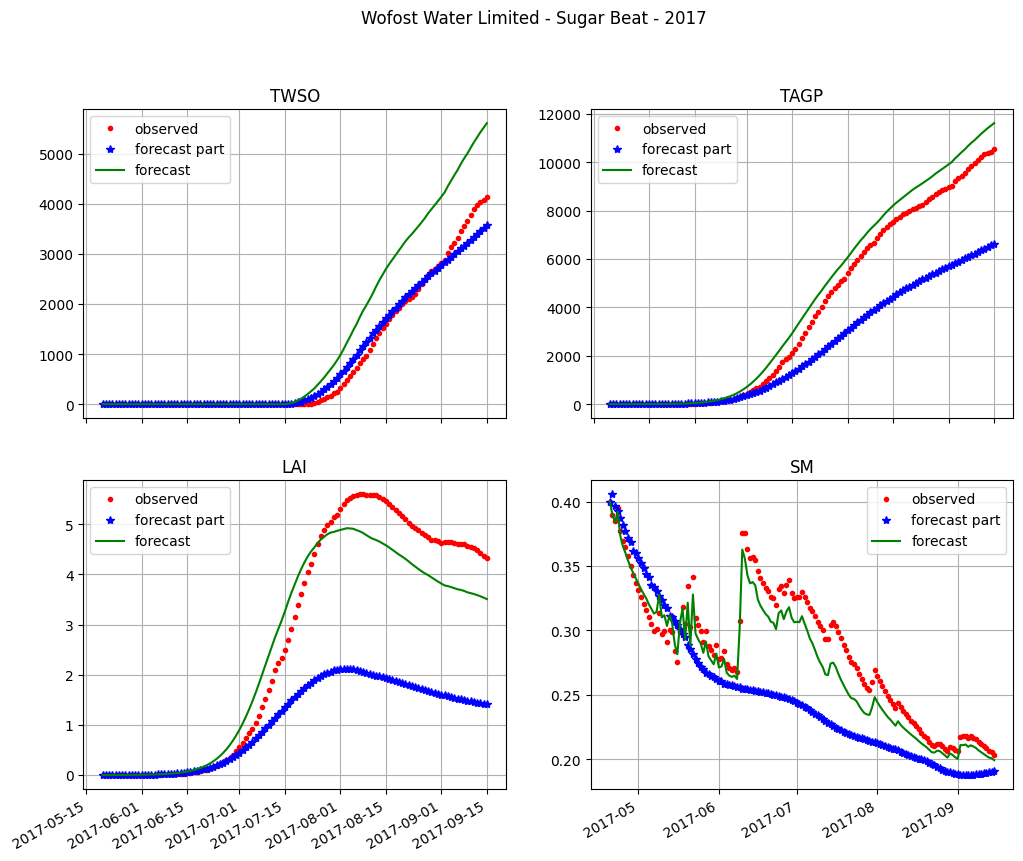

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for var, ax in zip(["TWSO", "TAGP", "LAI", "SM"], axes.flatten()):
    ax.plot_date(resSB_2017['Observed'].index, resSB_2017['Observed'][var], 'r.', label = 'observed')
    ax.plot_date(resSB_2017['Forecast Part'].index, resSB_2017['Forecast Part'][var], 'b*', label = 'forecast part')
    ax.plot_date(resSB_2017['Forecast'].index, resSB_2017['Forecast'][var], 'g-', label = 'forecast')
    ax.set_title(var)
    ax.grid()
    ax.legend()
fig.autofmt_xdate()
fig.suptitle('Wofost Water Limited - Sugar Beat - 2017')
fig.show()

In [28]:
crop_yield = np.round(resSB_2017['Observed']['TWSO'].values[-1], 2)
print(f"Crop yield - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")
crop_yield = np.round(resSB_2017['Forecast Part']['TWSO'].values[-1], 2)
print(f"Crop yield part forecast - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")
crop_yield = np.round(resSB_2017['Forecast']['TWSO'].values[-1], 2)
print(f"Crop yield forecast - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")

Crop yield - sugarbeet, Yield, kg/ha - 4148.26
Crop yield part forecast - sugarbeet, Yield, kg/ha - 3583.81
Crop yield forecast - sugarbeet, Yield, kg/ha - 5616.54


# Winter Wheat - 2017

In [29]:
agromanagement = yaml.load(yaml_agro_winter_wheat_2017, Loader)
firstkey = list(agromanagement[0])[0]
cropcalendar = agromanagement[0][firstkey]['CropCalendar'] 
cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [30]:
resWW_2017 = {}
for key, value in dictWeather.items():
    # Part forecast weather
    wfst71_FLD = Wofost71_WLP_FD(
        params,
        value,
        agromanagement
    )
    wfst71_FLD.run_till_terminate()
    df_FLD = pd.DataFrame(wfst71_FLD.get_output())
    df_FLD = df_FLD.set_index("day")
    resWW_2017[key] = df_FLD

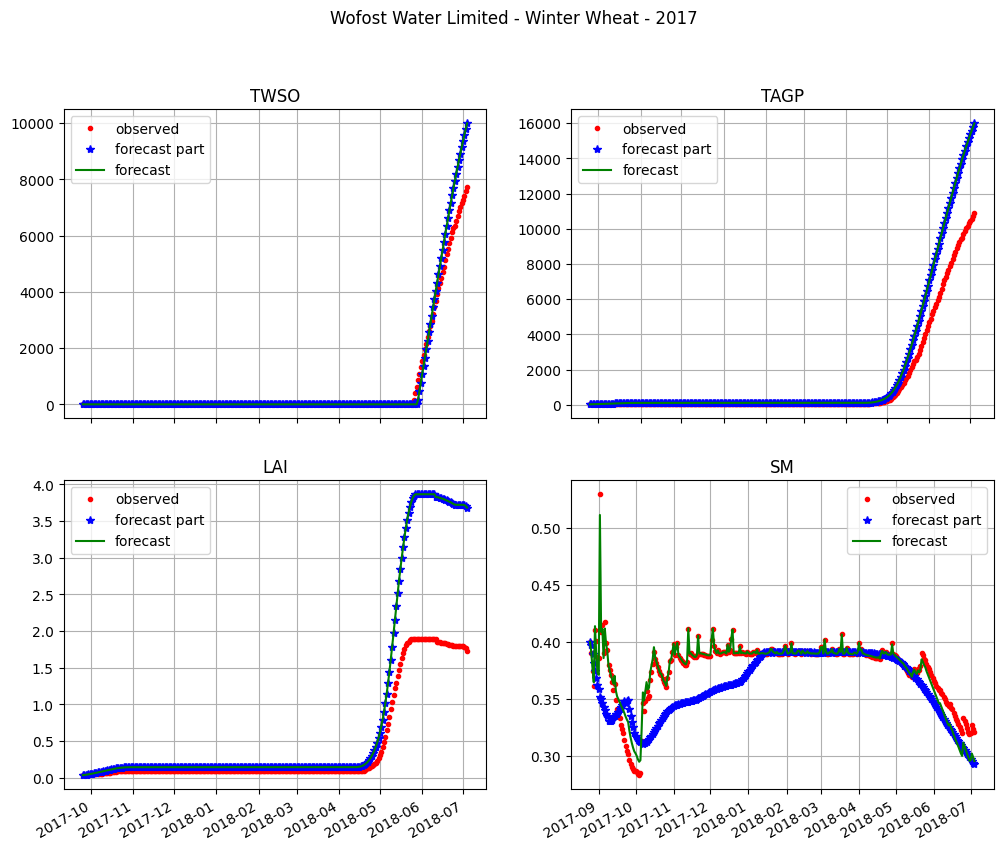

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for var, ax in zip(["TWSO", "TAGP", "LAI", "SM"], axes.flatten()):
    ax.plot_date(resWW_2017['Observed'].index, resWW_2017['Observed'][var], 'r.', label = 'observed')
    ax.plot_date(resWW_2017['Forecast Part'].index, resWW_2017['Forecast Part'][var], 'b*', label = 'forecast part')
    ax.plot_date(resWW_2017['Forecast'].index, resWW_2017['Forecast'][var], 'g-', label = 'forecast')
    ax.set_title(var)
    ax.grid()
    ax.legend()
fig.autofmt_xdate()
fig.suptitle('Wofost Water Limited - Winter Wheat - 2017')
fig.show()

In [32]:
crop_yield = np.round(resWW_2017['Observed']['TWSO'].values[-1], 2)
print(f"Crop yield - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")
crop_yield = np.round(resWW_2017['Forecast Part']['TWSO'].values[-1], 2)
print(f"Crop yield part forecast - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")
crop_yield = np.round(resWW_2017['Forecast']['TWSO'].values[-1], 2)
print(f"Crop yield forecast - {cropd.current_crop_name}, Yield, kg/ha - {crop_yield}")

Crop yield - wheat, Yield, kg/ha - 7724.74
Crop yield part forecast - wheat, Yield, kg/ha - 9990.28
Crop yield forecast - wheat, Yield, kg/ha - 9990.28


### Task 

-----

Problem with part_forecast

In [34]:
dictWeather = {
#     'Observed': weather_crop_model,
    'Forecast Part': weather_part_forecas_crop_model,
    'Forecast': weather_forecast_crop_model
}

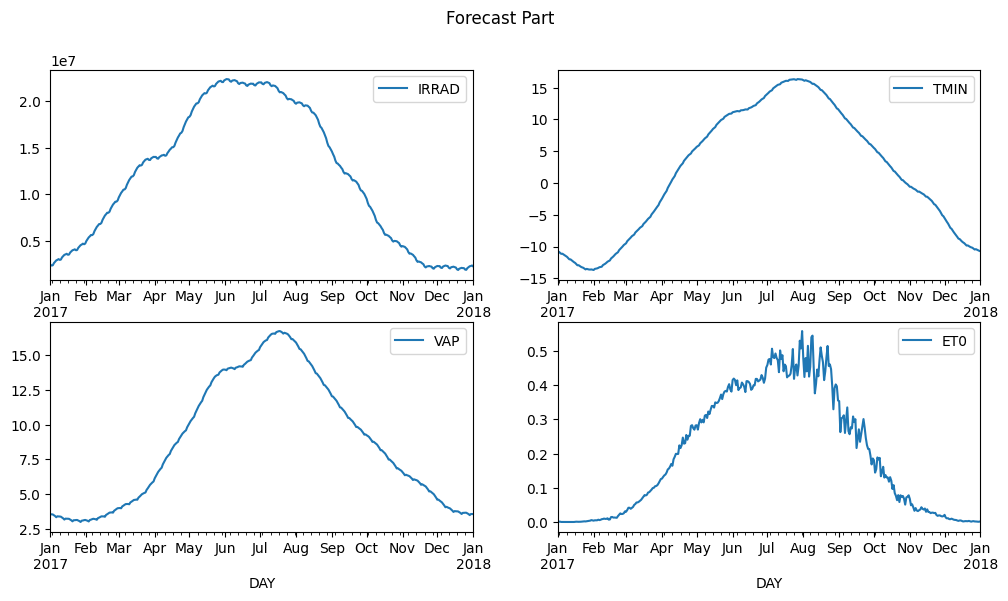

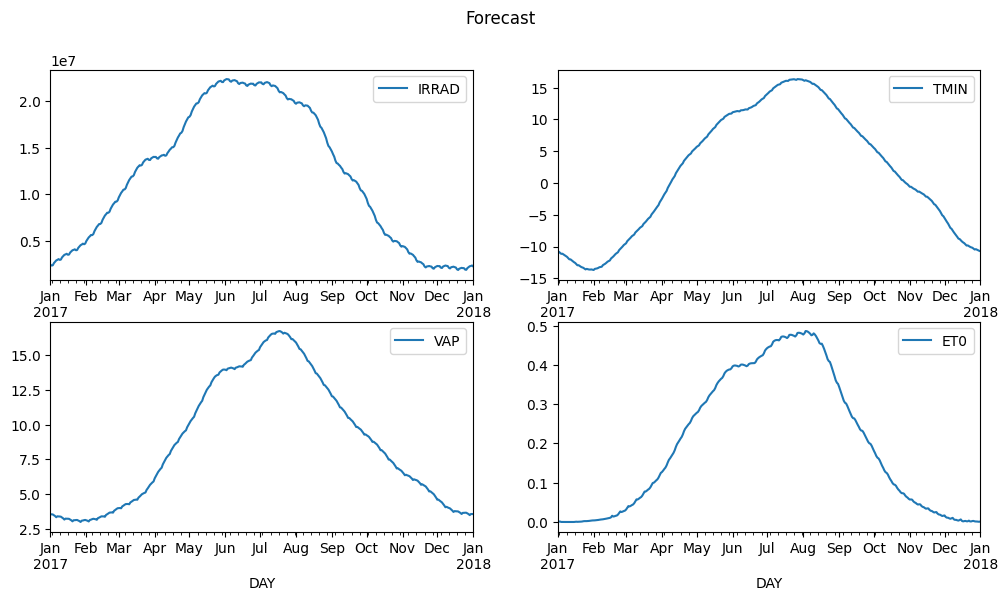

In [35]:
for key,value in dictWeather.items():
    w = pd.DataFrame(value.export())
    w['DAY'] = pd.to_datetime(w['DAY'])
#     mask = w['DAY']
    w = w.set_index('DAY')
    select = w.loc['2017-01-01':'2018-01-01']
    fig, (axes) = plt.subplots(2,2, figsize=(12,6))
    axes = (axes).flatten()
    for i, parameter in enumerate(['IRRAD', 'TMIN', 'VAP', 'ET0']):
        select[parameter].plot(ax=axes[i],label = parameter)
        axes[i].legend()
    fig.suptitle(key)

In [36]:
select.describe()

,LAT,LON,ELEV,IRRAD,TMIN,TMAX,VAP,RAIN,E0,ES0,ET0,WIND,TEMP
count,3.660000e+02,366.00,366.0,3.660000e+02,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,257.000000
mean,5.143000e+01,37.25,150.0,1.201084e+07,1.835661,10.775575,8.756431,0.171823,0.211112,0.183912,0.196715,3.057441,10.866265
std,7.115154e-15,0.00,0.0,7.238623e+06,9.865385,11.919603,4.569487,0.036492,0.201652,0.178958,0.175719,0.566605,9.223548
min,5.143000e+01,37.25,150.0,1.933353e+06,-13.695275,-6.837242,2.984446,0.102274,0.000000,0.000000,0.000000,2.186677,-7.834284
25%,5.143000e+01,37.25,150.0,4.655819e+06,-7.727352,-1.241171,4.264492,0.146064,0.008643,0.001639,0.023093,2.638993,3.535313
50%,5.143000e+01,37.25,150.0,1.221503e+07,2.420574,11.951007,8.092318,0.163230,0.151039,0.127371,0.154283,2.892414,13.260618
75%,5.143000e+01,37.25,150.0,1.964036e+07,11.168595,22.005245,13.350803,0.198393,0.433184,0.378984,0.384470,3.562052,18.154775
max,5.143000e+01,37.25,150.0,2.230917e+07,16.356498,28.098088,16.746435,0.258665,0.533605,0.471770,0.486053,4.386736,22.140566


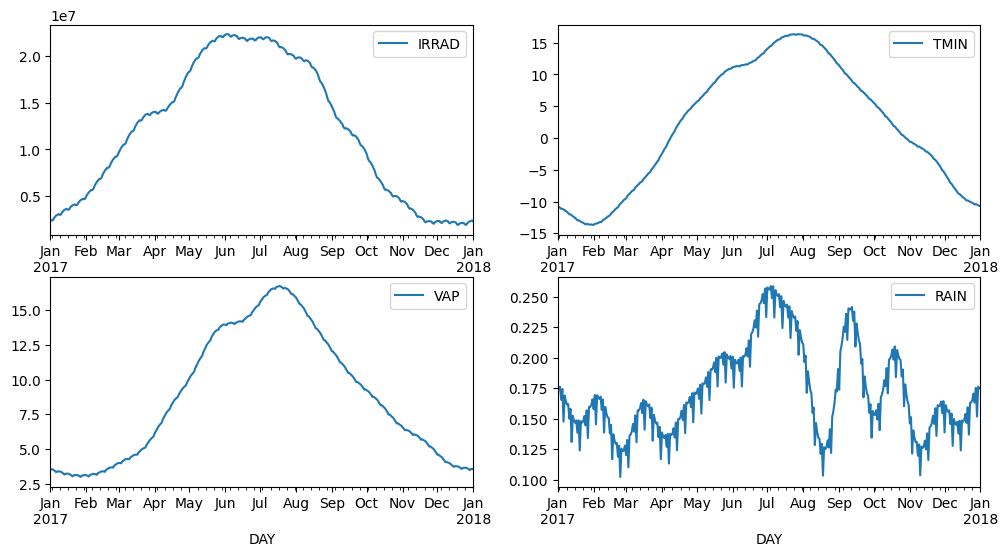

In [37]:
fig, (axes) = plt.subplots(2,2, figsize=(12,6))
axes = (axes).flatten()
for i, parameter in enumerate(['IRRAD', 'TMIN', 'VAP', 'RAIN']):
    select[parameter].plot(ax=axes[i],label = parameter)
    axes[i].legend()

<AxesSubplot:xlabel='DAY'>

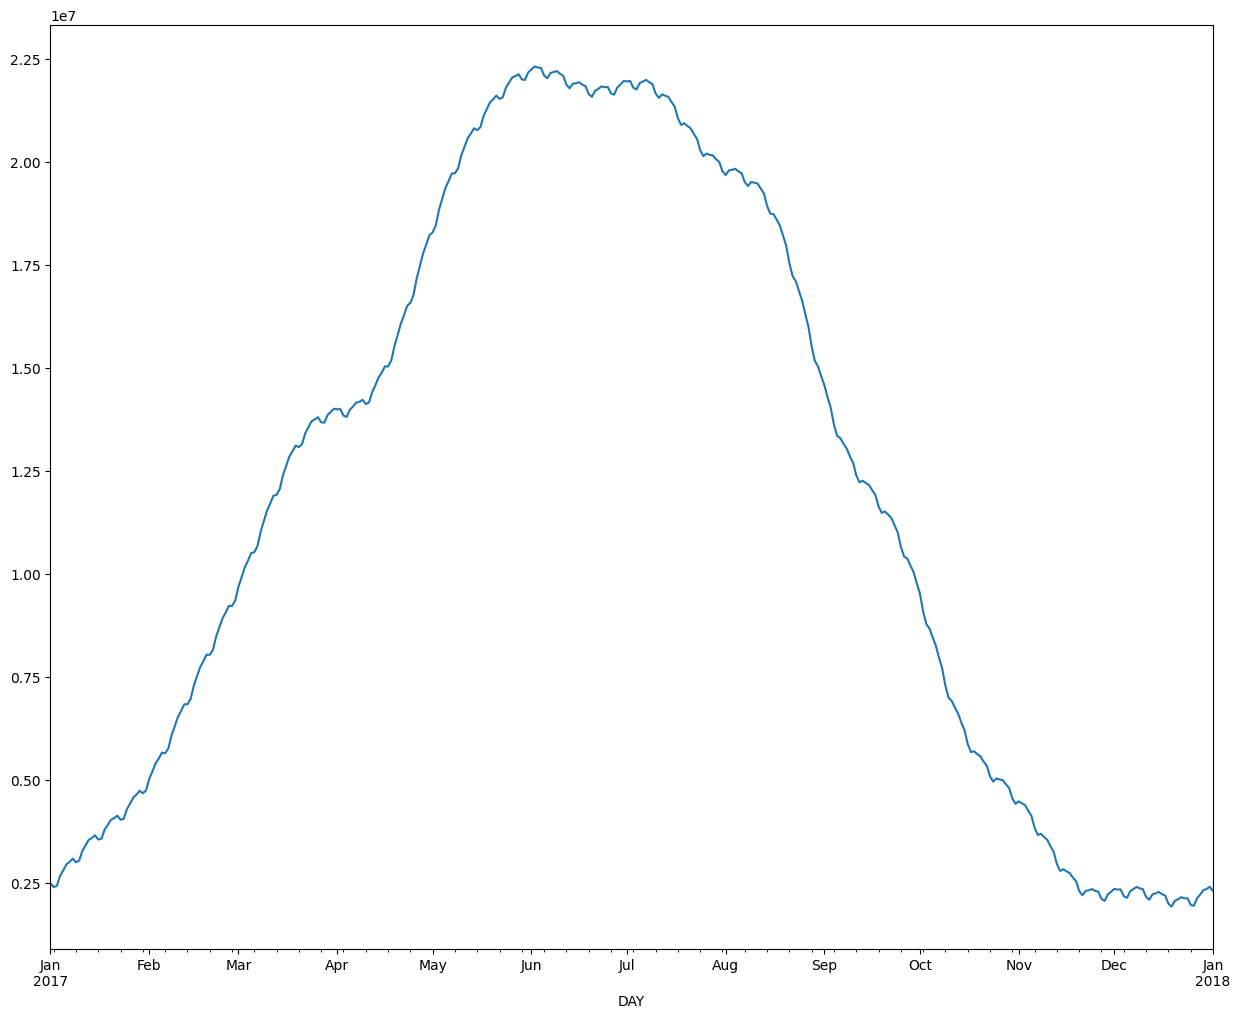

In [38]:

select['IRRAD'].plot()


In [39]:
w_part = pd.DataFrame(weather_part_forecas_crop_model.export())
w = pd.DataFrame(weather_forecast_crop_model.export())

In [40]:

# w.set_index('DAY')
w['DAY'] = pd.to_datetime(w['DAY'])

In [41]:
resWW_2017['Observed']

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2017-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,33.488117
2017-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390557,33.393688
2017-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374411,33.232228
2017-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361538,33.103495
2017-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.410600,33.594113
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30,1.475972,1.793353,10307.280134,7149.098904,891.174918,2267.006312,455.043825,0.230856,120.0,0.319116,38.293945
2018-07-01,1.494987,1.793353,10414.959692,7256.778462,891.174918,2267.006312,455.043825,0.218450,120.0,0.320662,38.479425
2018-07-02,1.510172,1.786504,10565.722298,7407.541068,891.174918,2267.006312,455.043825,0.237971,120.0,0.326890,39.226837
